In [1]:
import os
import time
import numpy as np
import random
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from EEGModels import EEGNet    

from config.arms_offline import config
from utils.visualize import showMe, showHistory
from utils.keras_generator import Generator
from utils.models.conv import get_model
%load_ext autoreload
%autoreload 2

sample_freq = 250


In [43]:
train_generator = Generator(config,split="train")
val_generator = Generator(config, split="val")

(900, 8, 500) (900,)
(900, 8, 128) (900,)
AUGMENTED (2700, 8, 128) (2700,)
(120, 8, 500) (120,)
(120, 8, 128) (120,)


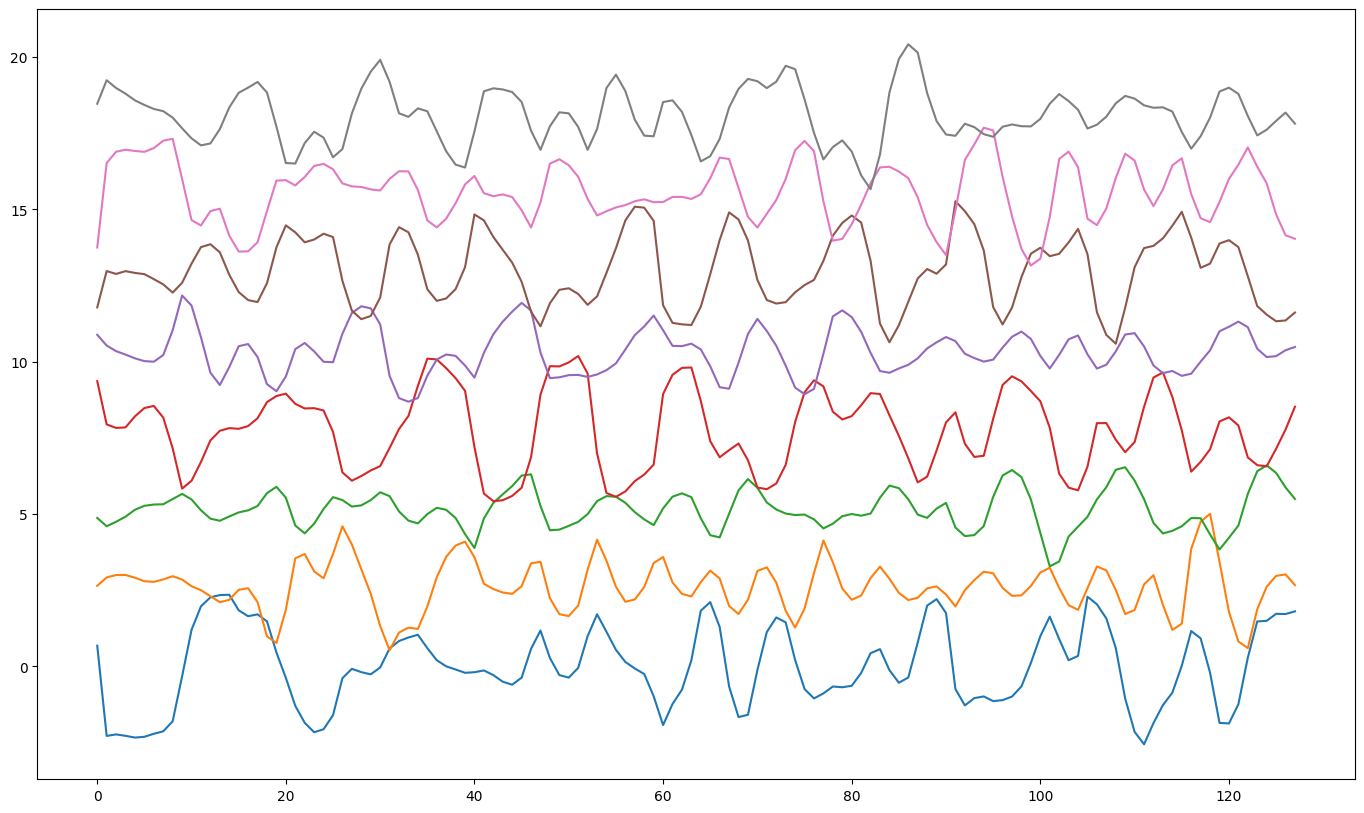

In [44]:
showMe(train_generator.X[5])

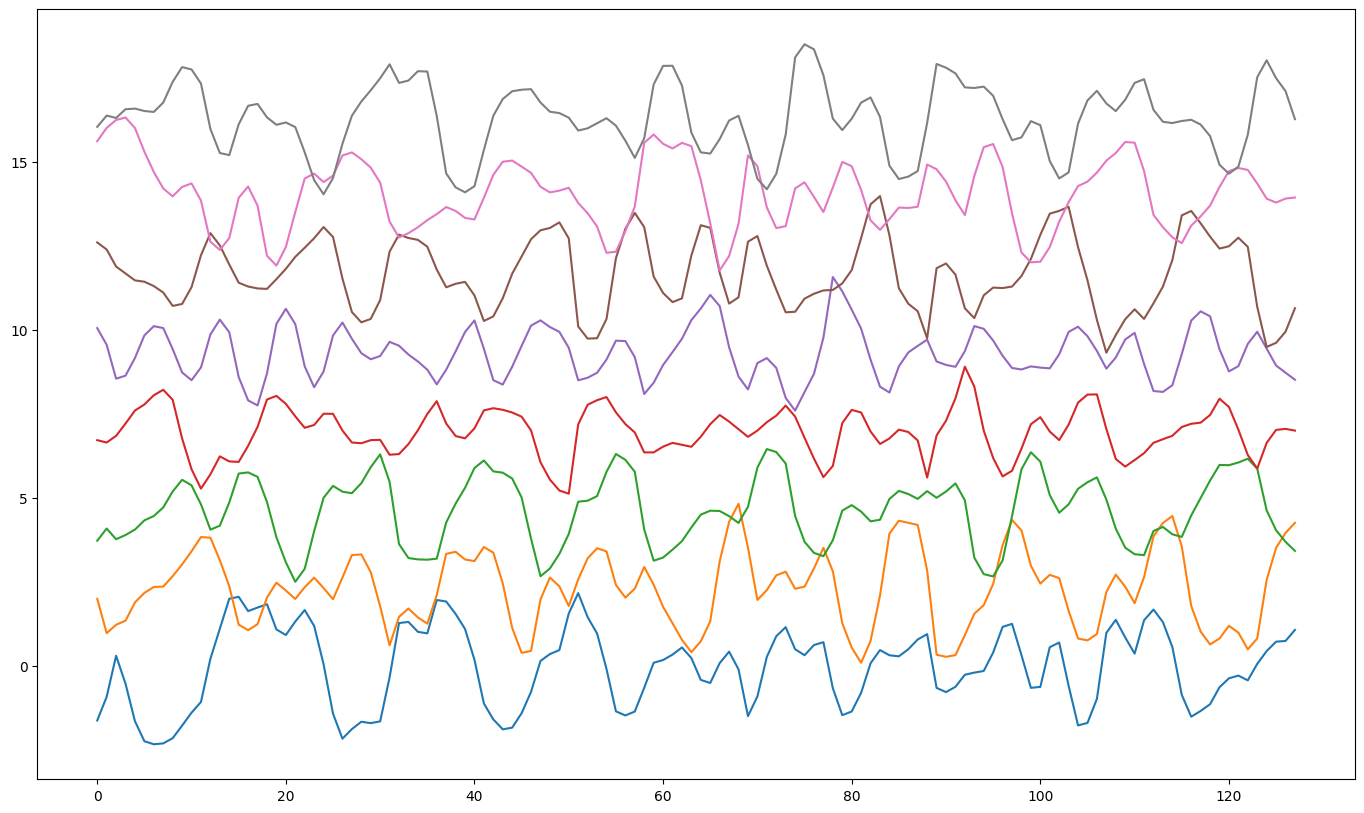

In [45]:
showMe(val_generator.X[5])

In [46]:
train_generator.expand_X()
val_generator.expand_X()

In [47]:

model = get_model(config.resample_to)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8, 128, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 8, 128, 8)         264       
                                                                 
 batch_normalization_17 (Bat  (None, 8, 128, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 128, 8)         520       
                                                                 
 batch_normalization_18 (Bat  (None, 8, 128, 8)        32        
 chNormalization)                                                
                                                                 
 global_max_pooling2d_8 (Glo  (None, 8)                0   

In [48]:
#lr_Scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
opt = keras.optimizers.Adam(lr=1e-3)
#opt = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

model.compile(optimizer=opt,
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
         )

c:\Code\Motor-Execution-Classifiaction\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
22/22 [==============================] - 1s 29ms/step - loss: 1.8186 - accuracy: 0.3398 - val_loss: 1.1065 - val_accuracy: 0.3333
Epoch 2/200
22/22 [==============================] - 0s 14ms/step - loss: 1.5570 - accuracy: 0.3663 - val_loss: 1.0961 - val_accuracy: 0.3583
Epoch 3/200
22/22 [==============================] - 0s 13ms/step - loss: 1.4424 - accuracy: 0.4102 - val_loss: 1.0974 - val_accuracy: 0.3333
Epoch 4/200
22/22 [==============================] - 0s 13ms/step - loss: 1.4474 - accuracy: 0.4152 - val_loss: 1.1028 - val_accuracy: 0.3083
Epoch 5/200
22/22 [==============================] - 0s 13ms/step - loss: 1.4096 - accuracy: 0.4246 - val_loss: 1.1017 - val_accuracy: 0.3333
Epoch 6/200
22/22 [==============================] - 0s 13ms/step - loss: 1.3707 - accuracy: 0.4311 - val_loss: 1.1027 - val_accuracy: 0.3333
Epoch 7/200
22/22 [==============================] - 0s 15ms/step - loss: 1.3116 - accuracy: 0.4576 - val_loss: 1.1055 - val_accuracy: 0.3583
Epoch 

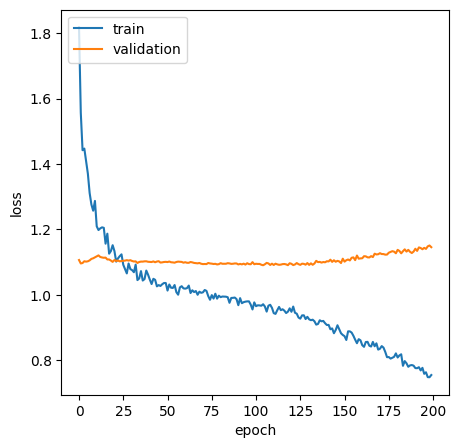

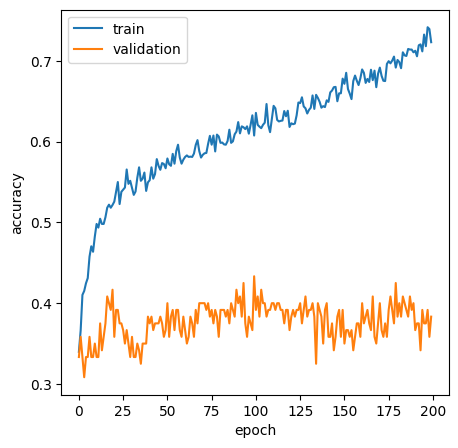

In [49]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=config.batch_size,
                    epochs=200)

showHistory(history)  